## Algoritmo de Maximización de la Esperanza
#### Estudiantes: Dennis Luna Acuña- Graciela Rivera Picado - Luis E. Vargas Porras

### Libraries

In [150]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import scipy
from scipy.stats import entropy
from scipy.stats import norm
from torch.distributions import normal
from torch.distributions import multivariate_normal
from scipy import stats 
import seaborn as sns 

### 1. Generate data with Gaussian distribution

*The data are artificially created with a 2-cluster Gaussian distribution with specific means and variances.*

tensor([ 9.4847,  8.5385,  7.4368,  8.7713,  9.4561,  7.6919,  8.9120,  7.0212,
        10.6019, 10.3848, 12.8809, 10.4188, 12.2312, 10.0721,  9.0372,  9.8760,
        10.3470,  8.9816,  8.9958, 11.5701, 11.1192,  8.4304, 11.3031, 10.4933,
         9.3776,  8.1282,  9.8312, 12.5979,  9.7553, 10.9083,  8.1048,  9.1356,
        10.2177, 10.2128,  8.4842, 12.0136, 11.6593,  8.9016, 10.8302,  9.4084,
        11.1425,  8.4147, 10.2234, 11.6909, 15.6213, 10.5690,  8.4904, 12.0659,
        10.7468, 10.4135, 10.6710,  9.3816, 11.1216,  9.8776,  9.2080, 10.2240,
         8.6461,  9.0095,  9.2091,  8.5127, 11.1948,  8.2910,  8.1267, 12.7455,
        10.5152,  7.8646,  9.9710,  7.4682, 10.4468,  9.3834, 11.3999,  8.8663,
         7.9348, 12.4644, 10.1081,  9.9502,  9.6188, 10.3607, 10.8591, 10.9493,
         9.1192,  9.5753, 11.7072,  8.7671, 12.4201,  9.4534, 10.4105,  9.9707,
         8.0785, 11.6616, 10.7616, 11.5214, 12.0980, 12.3159, 11.0958, 12.9452,
        10.3348,  8.4492,  9.4830,  8.67

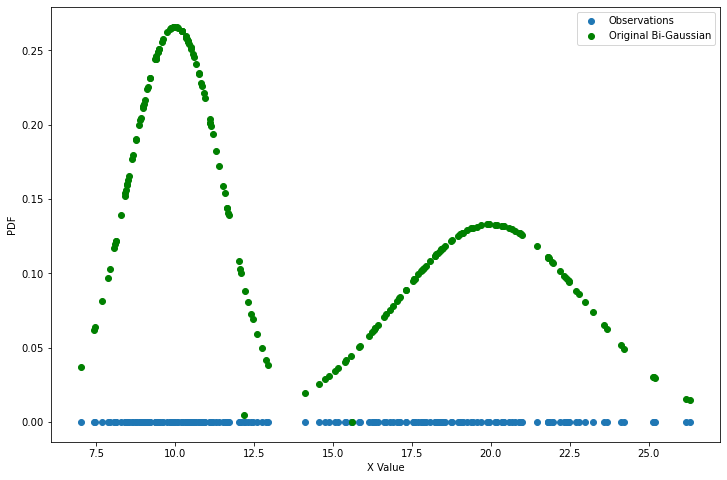

In [182]:
def createDataOneClass(means, std, numberSamplesPerClass):
    normal_dist = torch.distributions.Normal(means,std)
    gaussian_sample = normal_dist.sample((numberSamplesPerClass,1)).squeeze()
    
    return gaussian_sample


def generate_data(numberSamplesPerClass, mean1, mean2 , stds1 , stds2 ):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """

    samplesClass1 = createDataOneClass(mean1, stds1, numberSamplesPerClass)
    samplesClass2 = createDataOneClass(mean2, stds2, numberSamplesPerClass)
    #Concatenates
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    print (samplesAll)

    # Plot Data
    y = np.zeros_like(samplesAll)
    plt.figure(figsize=(12,8)) 
    plt.scatter(samplesAll, y, label='Observations')
    #plt.title('Plotting)
    plt.xlabel('X Value')
    plt.ylabel('PDF')

    #Plot densities Functions
    plt.scatter(samplesClass1, norm.pdf(samplesClass1, mean1, stds1), color="green", label='Original Bi-Gaussian')
    plt.scatter(samplesClass2, norm.pdf(samplesClass2, mean2, stds2), color="green")
    plt.legend()
    plt.show()

    
    return (samplesAll, samplesClass1, samplesClass2)

'''
Creates data with gaussian distribution
'''

#Call Function generate Data
X_allSamples, X1_samples, X2_samples = generate_data(numberSamplesPerClass=100, mean1=10.0, mean2=20.0, stds1=1.5, stds2=3.0)



### 2. Create init_random_parameters

In [152]:
def init_random_parameters(K=2, range_mean = [1,10], range_std = [1,5]):
    
    np.random.seed(2)    
    
    mean = torch.randint(range_mean[0],range_mean[1],(K,1))
    std  = torch.randint(range_std[0], range_std[1],(K,1))  
    
    W = torch.cat((mean, std), 1)
    
    return W

#test

W_parameters = init_random_parameters(K=2, range_mean = [1,50], range_std = [1,10])
W_parameters

tensor([[ 9,  3],
        [14,  3]])

### 3. Likelihood Gaussian Observation Function

In [153]:
#Propuesta2Gracielav1
def calculate_likelihood_gaussian_observation(x_n,mu_k,sigma_k):
    
    p_x1 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[0]))) * np.exp(-0.5*((x_n-mu_k[0])/sigma_k[0])**2)
    p_x2 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[1]))) * np.exp(-0.5*((x_n-mu_k[1])/sigma_k[1])**2) 
    #p_xAll = torch.Tensor([p_x1,p_x2])
    return p_x1,p_x2
    
calculate_likelihood_gaussian_observation(X_allSamples[0], mu_k = [10,20], sigma_k = [1.5,3])

(tensor(1.4341e-07), tensor(2.7822e-09))

In [154]:
#Propuesta2Graciela_conLOG
def calculate_likelihood_gaussian_observationLOG(x_n,mu_k,sigma_k):
    
    p_x1 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[0]))) * np.exp(-0.5*((x_n-mu_k[0])/sigma_k[0])**2)
    logp_x1= np.log(p_x1)
    p_x2 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[1]))) * np.exp(-0.5*((x_n-mu_k[1])/sigma_k[1])**2)
    logp_x2 =  np.log(p_x2)
    return logp_x1,logp_x2

calculate_likelihood_gaussian_observationLOG(X_allSamples[0], mu_k = [10,20], sigma_k = [1.5,3])

(tensor(-15.7576), tensor(-19.7000))

### 4. Calculate_membership

In [155]:
def calculate_membership_dataset(X_dataset,Parameters_matrix):
    #crear una matriz con ceros
    N = len(X_dataset)
    k = 2
    M = torch.zeros((N, k))
    
    #calculate_likelihood
    likelihood1,likelihood2 = calculate_likelihood_gaussian_observation(X_dataset,Parameters_matrix[:,0],Parameters_matrix[:,1])
    
    #print("likelihood2:", likelihood2.reshape([N, 1]))
    likelihoodALL = torch.cat((likelihood1.reshape([N, 1]), likelihood2.reshape([N, 1])), 1)
    
    M[:,0] = likelihoodALL[:,0] > likelihoodALL[:,1] 
    M[:,1] = likelihoodALL[:,0] < likelihoodALL[:,1] 
    
    return M

#fix_param = torch.tensor([[10,1.5],[20,3]])
Membership_Matrix = calculate_membership_dataset(X_allSamples,W_parameters)
#Membership_Matrix


## 5. Recalculate_parameters

In [187]:
def recalculate_parameters(X_dataset,Membership_data): 
    
    N = len(X_dataset)   
    
    X1 = torch.cat((X_dataset.reshape([N, 1]),Membership_data[:,0].reshape([N, 1])),1)
    X2 = torch.cat((X_dataset.reshape([N, 1]),Membership_data[:,1].reshape([N, 1])),1)
    
    X1_filtrada = X1[X1[:,1] == 1][:,0]
    X2_filtrada = X2[X2[:,1] == 1][:,0]
    
    mu_x1 = torch.mean(X1_filtrada)
    mu_x2 = torch.mean(X2_filtrada)
    
    sigma_x1 = torch.std(X1_filtrada)
    sigma_x2 = torch.std(X2_filtrada)
    
    new_W = torch.tensor([[mu_x1,sigma_x1],[mu_x2,sigma_x2]])
  
    return new_W
    
recalculate_parameters(X_allSamples,Membership_Matrix)
    

tensor([[10.0283,  1.4892],
        [18.9008,  3.4088]])

### 6. Corridas del Algoritmo

Iteration number: 0
Parameters values used: tensor([[ 9,  4],
        [37,  7]])

Iteration number: 1
Parameters values used: tensor([[12.6165,  3.7399],
        [22.0247,  1.7883]])

Iteration number: 2
Parameters values used: tensor([[12.2202,  3.4791],
        [21.5264,  1.9726]])

Iteration number: 3
Parameters values used: tensor([[11.7730,  3.1671],
        [21.0218,  2.1536]])

Iteration number: 4
Parameters values used: tensor([[11.2079,  2.7059],
        [20.4838,  2.3307]])

Iteration number: 5
Parameters values used: tensor([[10.6290,  2.1388],
        [19.9562,  2.5394]])

Iteration number: 6
Parameters values used: tensor([[10.2026,  1.6308],
        [19.5438,  2.7402]])

Iteration number: 7
Parameters values used: tensor([[10.0277,  1.4001],
        [19.3450,  2.8578]])

Iteration number: 8
Parameters values used: tensor([[10.0277,  1.4001],
        [19.3450,  2.8578]])

Iteration number: 9
Parameters values used: tensor([[10.0277,  1.4001],
        [19.3450,  2.8578]])



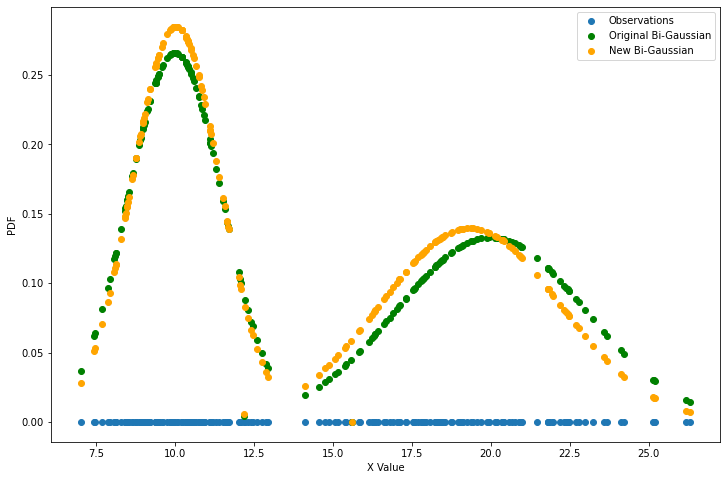

In [191]:
W_parameters = init_random_parameters(K=2, range_mean = [1,50], range_std = [1,10])

for i in range(20):
    print("Iteration number: %s"%i)
    print("Parameters values used: %s\n"%W_parameters)
    new_M = calculate_membership_dataset(X_allSamples,W_parameters)
    W_parameters = recalculate_parameters(X_allSamples,new_M)     

# Plot Data
y = np.zeros_like(X_allSamples)
plt.figure(figsize=(12,8))
plt.scatter(X_allSamples, y, label="Observations")
#plt.title('Plotting)
plt.xlabel('X Value')
plt.ylabel('PDF')

#Plot densities Functions
plt.scatter(X1_samples, norm.pdf(X1_samples, 10, 1.5), color="green", label='Original Bi-Gaussian')
plt.scatter(X2_samples, norm.pdf(X2_samples, 20, 3), color="green") 
plt.scatter(X1_samples, norm.pdf(X1_samples, W_parameters[0,0], W_parameters[0,1]), color='orange', label='New Bi-Gaussian')
plt.scatter(X2_samples, norm.pdf(X2_samples, W_parameters[1,0], W_parameters[1,1]), color='orange')      
plt.legend()
plt.show()